# Tile experiments

0 - lodged
1 - not lodged
2 - altro 

In [1]:
from tile_class import TileOperations
from classifier import predict, predict_batch
import pickle
import os

from tqdm import tqdm
from time import sleep

In [2]:
tiles_dir = '/home/bota/Downloads/projtiles1/'
gps_csv = '/home/bota/Desktop/active_sensing/src/gpstiles.csv'
raw_imgs_dir = "/media/bota/BOTA/wheat/APPEZZAMENTO_PICCOLO/"

# Initialize TileOperations
tile_ops = TileOperations(tiles_dir, gps_csv, raw_imgs_dir)


# Test finding the closest image
tile_to_test = (20, 20)
closest_image_path, minimum_distance = tile_ops.find_closest_image(tile_to_test)

print(f"Selected tile image: {closest_image_path}")
print(f"Distance to tile center: {minimum_distance:.2f}")
# """

Selected tile image: DJI_20240607121633_0156_D_point19_tile20_20_crop.png
Distance to tile center: 8.44


In [3]:
pred_file = "prediction_on_tiles.pickle"
if os.path.isfile(pred_file):
    with open(pred_file, 'rb') as handle:
        predictions = pickle.load(handle)
else:

    predictions = {}
    batch_size = 100  # Define the maximum number of images per batch for predict_batch
    tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]
    batched_images = []
    batched_tiles = []
    pbar = tqdm(total=len(tiles))

    for tile_to_test in tiles:
        raw_imgs = sorted(tile_ops.get_rawimagepath(tile_to_test))
        to_predict = [tiles_dir + raw_img for raw_img in raw_imgs]
        
        if to_predict:
            batched_images.extend(to_predict)
            batched_tiles.extend([tile_to_test] * len(to_predict))
        
        # Process the batch if it reaches the batch_size or if it's the last tile
        if len(batched_images) >= batch_size or tile_to_test == tiles[-1]:
            batch_predictions = predict_batch(batched_images)  # Predict for the batched images
            
            # Assign predictions back to their respective tiles
            for tile, prediction in zip(batched_tiles, batch_predictions):
                if tile not in predictions:
                    predictions[tile] = []
                predictions[tile].append(prediction)
            
            # Clear the batch
            batched_images.clear()
            batched_tiles.clear()
        
        sleep(0.01)
        pbar.update(1)

    pbar.close()
    with open(pred_file, 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)



100%|██████████| 6600/6600 [04:47<00:00, 22.99it/s]


In [4]:
predictions[(45,45)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1]

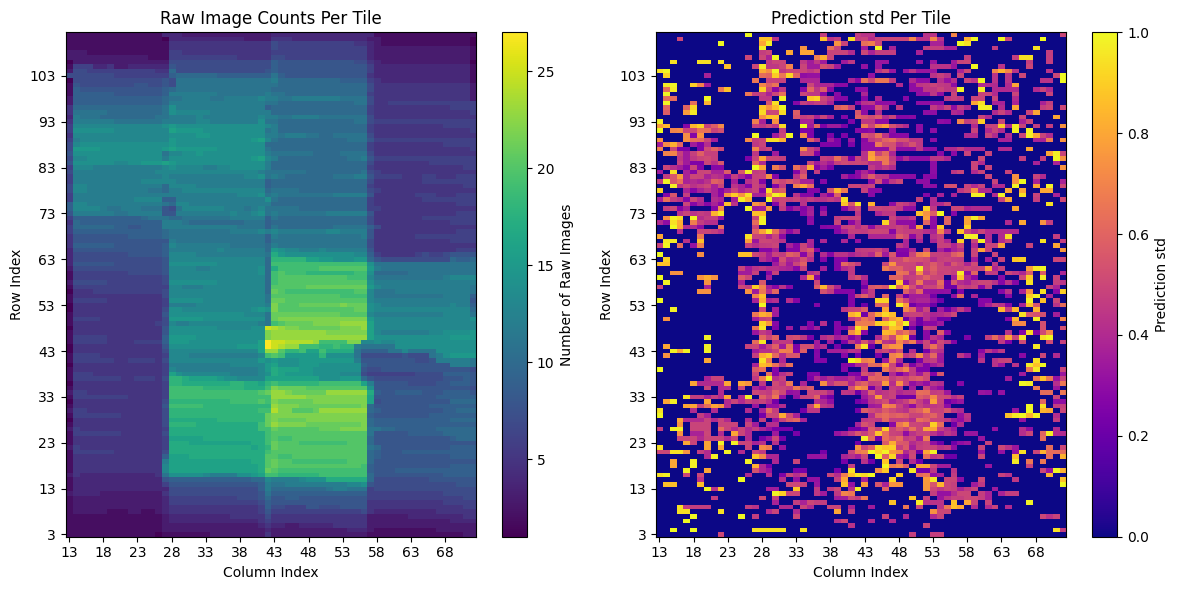

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the data

rows = range(3, 113)
cols = range(13, 73)
raw_img_counts = np.zeros((len(rows), len(cols)))
persistence = np.zeros((len(rows), len(cols)))
std = np.zeros((len(rows), len(cols)))
# Populate the raw_img_counts and persistence arrays
for (row, col), preds in predictions.items():
    row_idx = row - 3
    col_idx = col - 13
    raw_img_counts[row_idx, col_idx] = len(preds)
    if preds:  # Avoid division by zero
        persistence[row_idx, col_idx] = sum(preds) / len(preds)
        std[row_idx, col_idx] = np.std(preds)


# Plot 1: Raw image counts per tile
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(raw_img_counts, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Number of Raw Images')
plt.title('Raw Image Counts Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Plot 2: Prediction persistence per tile
plt.subplot(1, 2, 2)
plt.imshow(std, aspect='auto', cmap='plasma', origin='lower')
plt.colorbar(label='Prediction std')
plt.title('Prediction std Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Show the plots
plt.tight_layout()
plt.show()


In [66]:
# Collect indices where elements are greater than x
std_thr = 0.99
indices = np.where(std > std_thr)

high_std_tiles = list(zip(indices[0]+3, indices[1]+13))
print(f"{len(high_std_tiles)} tiles with std higher than {std_thr}, which is {round(len(high_std_tiles)/len(std), 2)}% of overall")

59 tiles with std higher than 0.99, which is 0.54% of overall


In [20]:
import matplotlib.patches as mpatches

In [80]:
def plot_fov_2d(fov_corners_all, centers, tile_to_test):
    fig, ax = plt.subplots(figsize=(8, 8))
    preds = predictions[(tile_to_test)]
    colors= ["r","g","b"]
    colors_list = [
        "#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#8A2BE2", "#A52A2A", 
        "#D2691E", "#FF6347", "#F0E68C", "#98FB98", "#8B4513", "#800080", "#FF00FF", 
        "#FFD700", "#ADFF2F", "#1E90FF", "#32CD32", "#FF1493", "#B22222", "#FF4500", 
        "#2E8B57", "#A52A2A", "#F4A300", "#2F4F4F", "#8B008B", "#00CED1"
    ]

    for i, point in enumerate(fov_corners_all):
        # rectangle
        corners_ = order_fov_corners(point)
        color = colors[preds[i]]
        ax.fill(corners_[:, 1], corners_[:, 0], color = color, alpha=0.2, edgecolor=colors_list[i], linewidth=1)
        # rectangle center
        center = centers[i]
        ax.scatter(center[1], center[0],  color=color, alpha=1)

        # Line from center to origin
        ax.plot([0, center[1]], [0, center[0]], linestyle="--", linewidth=0.8)

        # Calculate and annotate Euclidean distance
        distance = np.sqrt(center[0]**2 + center[1]**2)
        midpoint_x = center[1] *3/ 4
        midpoint_y = center[0] *3/ 4
        ax.annotate(f"{distance:.2f} m", (midpoint_x, midpoint_y), fontsize=7)

    for i, point in enumerate(fov_corners_all):
        # rectangle
        color = colors[preds[i]]
        # rectangle center
        center = centers[i]
        ax.scatter(center[1], center[0],  color=color, alpha=1)

    # 1mx1m tile in the center
    ax.fill([-0.5,-0.5,0.5,0.5], [-0.5,0.5,0.5,-0.5],"black", alpha=0.8, )    
    # ax.scatter([0], [0])

    ax.set_xlabel("East y+")
    ax.set_ylabel("North x+")
    ax.set_aspect("equal", "box")
    ax.set_title(f"raw images footprints with its centers wrt tile {tile_to_test}")
    # ax.legend(handles=[])
    legend_patches = [
        mpatches.Patch(color="r", label="Lodged"),
        mpatches.Patch(color="g", label="Not Lodged"),
        mpatches.Patch(color="b", label="Altro"),
    ]
    ax.legend(handles=legend_patches, loc="upper right")

    plt.show()

def order_fov_corners(corners):
    corners = np.array(corners)
    centroid = np.mean(corners[:, :2], axis=0)
    angles = np.arctan2(corners[:, 1] - centroid[1], corners[:, 0] - centroid[0])
    ordered_corners = corners[np.argsort(angles)]
    return ordered_corners

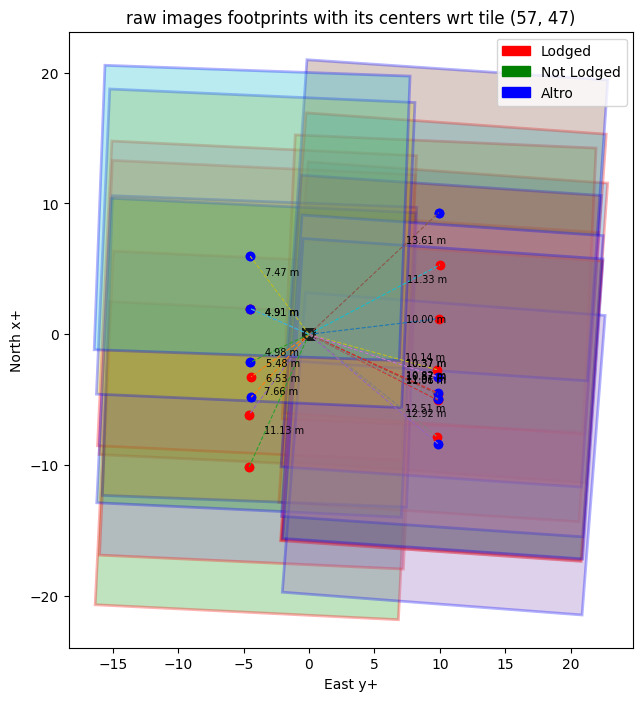

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2]


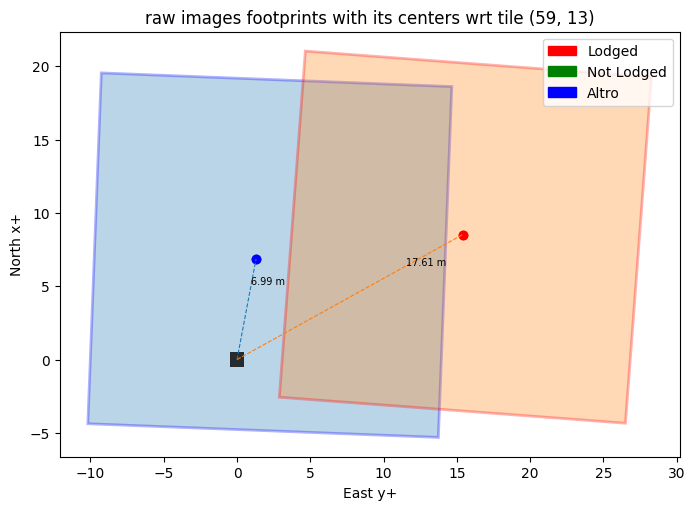

[2, 0]


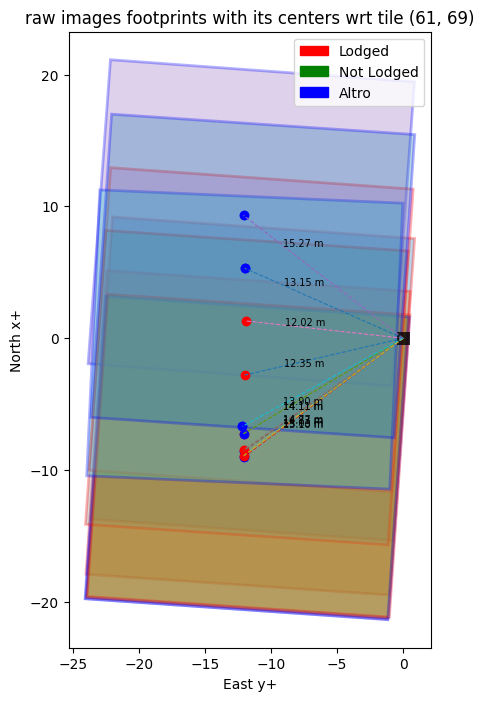

[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2]


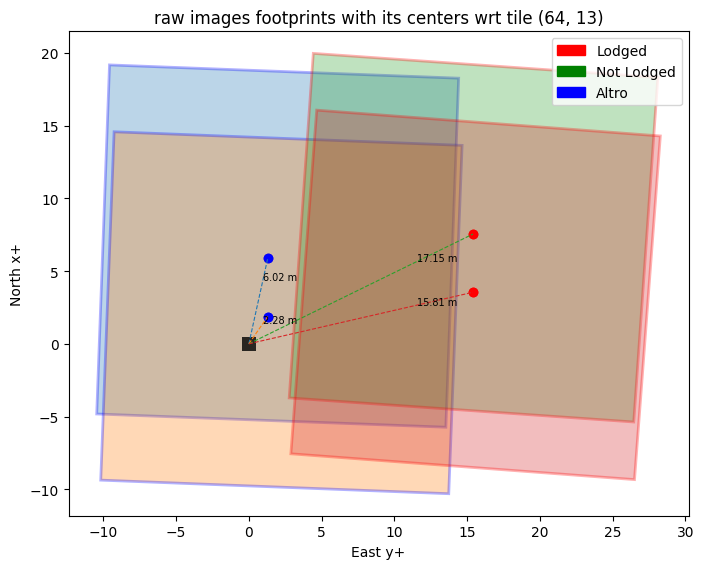

[2, 2, 0, 0]


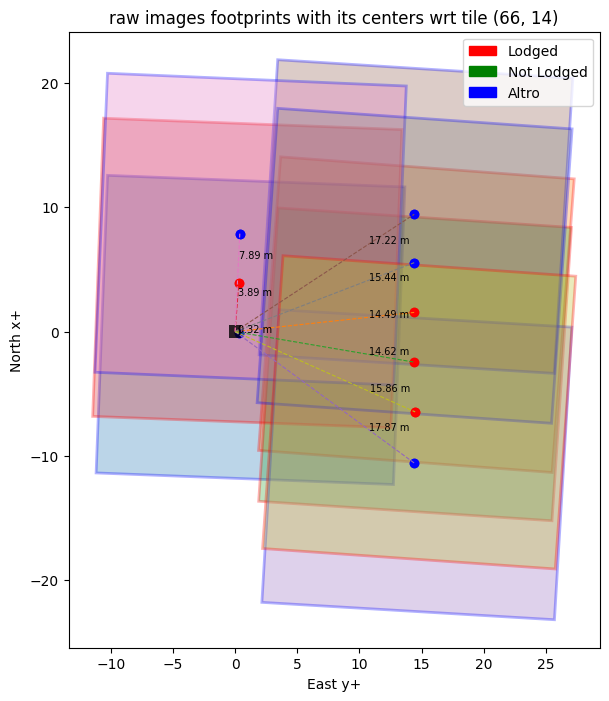

[2, 0, 0, 0, 2, 2, 2, 2, 0]


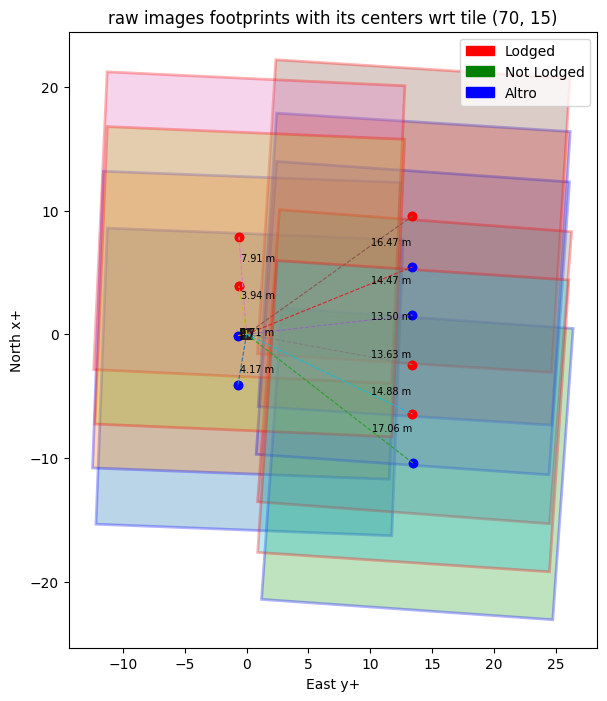

[2, 2, 2, 2, 2, 0, 0, 0, 0, 0]


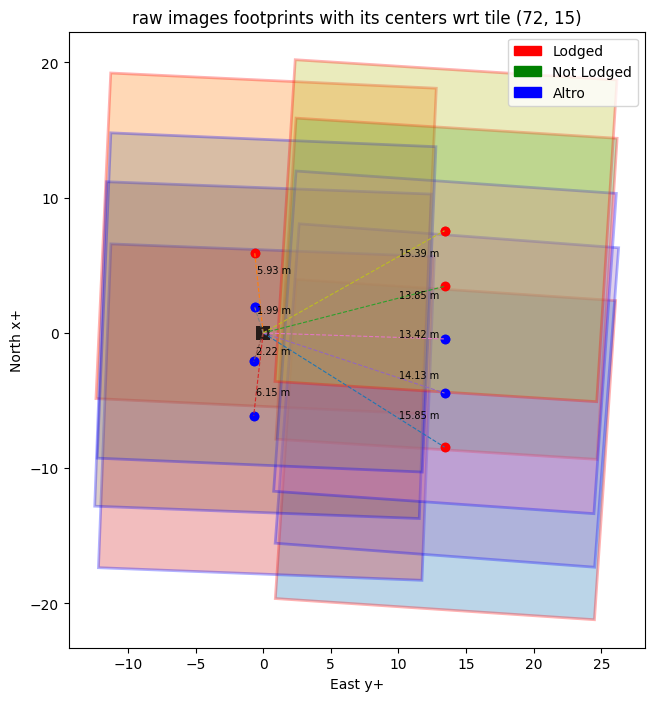

[0, 0, 0, 2, 2, 2, 2, 2, 0]


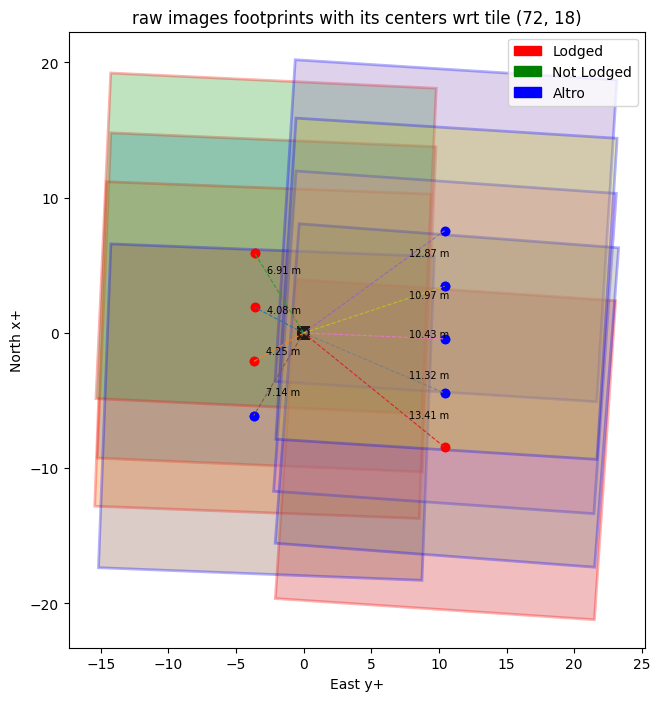

[0, 0, 0, 0, 2, 2, 2, 2, 2]


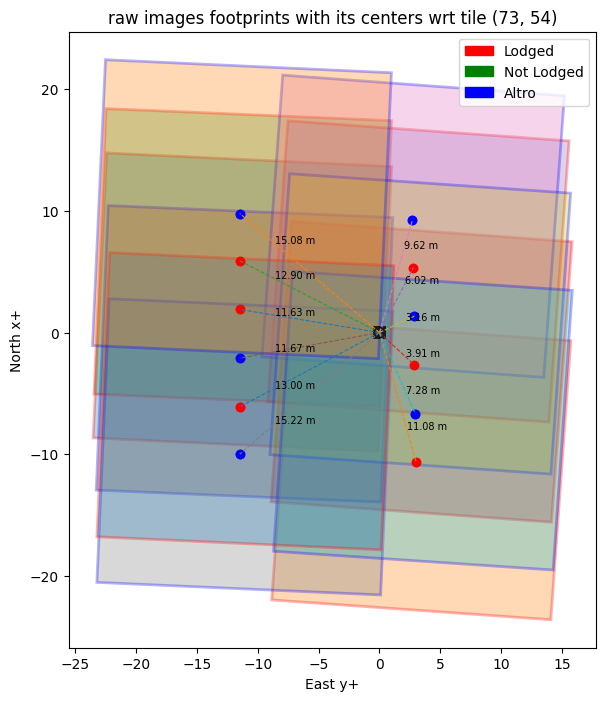

[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2]


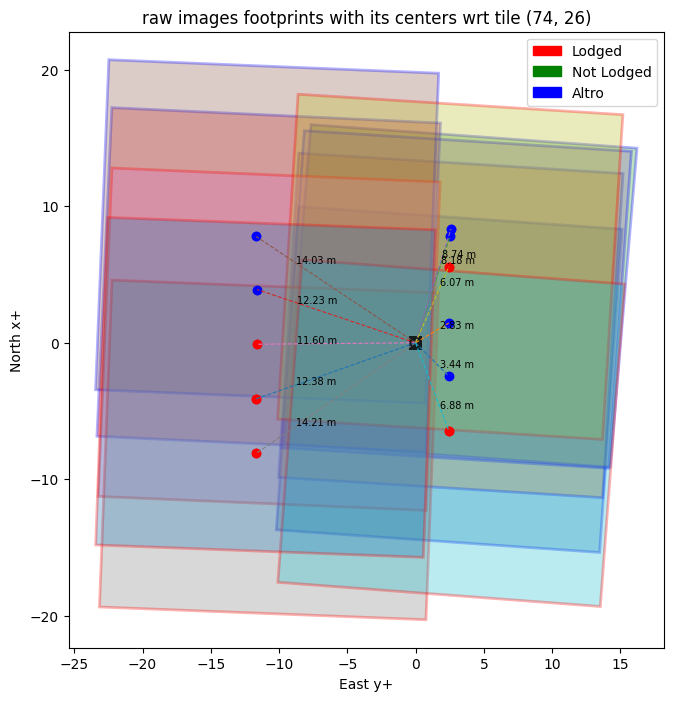

[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]


In [81]:
# tile_to_test = (45,45)

tile_to_test = (3,20)
for tile_to_test in high_std_tiles[25:35]:
    fov_corners_all, centers = tile_ops.locate_wrt_tile(tile_to_test, ref_rel_alt=20)
    plot_fov_2d(fov_corners_all, centers, tile_to_test)
    print(predictions[tile_to_test])
    # for (row, col), preds in predictions.items():
    # print(f"corners {fov_corners_all}")

In [10]:
fov_corners_all[0]

array([[ 13.67211735,   6.1750311 ,  39.60177128],
       [ -8.96183744,   4.51197612,  38.82261761],
       [ -7.30522805, -18.13484029,  39.03731082],
       [ 15.32872673, -16.47178531,  39.81646449]])

In [11]:
plot_fov_2d(fov_corners_all, centers)

TypeError: plot_fov_2d() missing 1 required positional argument: 'tile_to_test'